In [268]:
# Base
import os
import math
import itertools
import numpy as np
import pandas as pd

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates

# Prétraitement
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, ParameterGrid
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Deep Learning - LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import Huber
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.regularizers import l2

# ARIMA
from pmdarima import auto_arima as pm

# Prophet
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics



# Séries temporelles statistiques
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# NLP / Sentiment
#from textblob import TextBlob

# Scraping Reddit
#from psaw import PushshiftAPI

# Utilitaire
#from tqdm.auto import tqdm
#from scipy.stats import kendalltau


# Loading and Preparing Data

In [217]:
# Read the CSV file
csv_filename = 'Bitcoin_historical_data.csv'
df = pd.read_csv(csv_filename)

# Display the first few rows of the dataframe
df


timeOpen                 timeClose  \
0     2025-04-28T00:00:00.000Z  2025-04-28T23:59:59.999Z   
1     2025-04-27T00:00:00.000Z  2025-04-27T23:59:59.999Z   
2     2025-04-26T00:00:00.000Z  2025-04-26T23:59:59.999Z   
3     2025-04-25T00:00:00.000Z  2025-04-25T23:59:59.999Z   
4     2025-04-24T00:00:00.000Z  2025-04-24T23:59:59.999Z   
...                        ...                       ...   
3687  2015-03-25T00:00:00.000Z  2015-03-25T23:59:59.999Z   
3688  2015-03-24T00:00:00.000Z  2015-03-24T23:59:59.999Z   
3689  2015-03-23T00:00:00.000Z  2015-03-23T23:59:59.999Z   
3690  2015-03-22T00:00:00.000Z  2015-03-22T23:59:59.999Z   
3691  2015-03-21T00:00:00.000Z  2015-03-21T23:59:59.999Z   

                      timeHigh                   timeLow  name          open  \
0     2025-04-28T12:48:00.000Z  2025-04-28T01:56:00.000Z  2781  93755.303605   
1     2025-04-27T01:18:00.000Z  2025-04-27T13:08:00.000Z  2781  94660.909208   
2     2025-04-26T01:37:00.000Z  2025-04-26T13:47:00.000Z  2781  94714.646371   
3     2025-04-25T14:57:00.000Z  2025-04-25T03:03:00.000Z  2781  93954.249820   
4     2025-04-24T23:35:00.000Z  2025-04-24T08:50:00.000Z  2781  93692.395952   
...                        ...                       ...   ...           ...   
3687  2015-03-25T13:24:22.000Z  2015-03-25T07:34:21.000Z  2781    247.472000   
3688  2015-03-24T00:34:22.000Z  2015-03-24T14:34:21.000Z  2781    266.576996   
3689  2015-03-23T15:09:22.000Z  2015-03-23T19:34:22.000Z  2781    267.894989   
3690  2015-03-22T23:14:21.000Z  2015-03-22T02:39:21.000Z  2781    259.916992   
3691  2015-03-21T16:09:21.000Z  2015-03-21T06:34:21.000Z  2781    261.644012   

              high           low         close        volume     marketCap  \
0     95598.492237  92860.808221  94978.752504  3.236345e+10  1.886098e+12   
1     95301.206377  93665.397357  93754.846738  1.809037e+10  1.861696e+12   
2     95251.359438  93927.250628  94646.928112  1.761283e+10  1.879642e+12   
3     95768.392467  92898.593091  94720.498018  4.091523e+10  1.880787e+12   
4     94016.194428  91696.714114  93943.793416  3.148318e+10  1.865529e+12   
...            ...           ...           ...           ...           ...   
3687    249.190002    236.514999    246.197006  3.586690e+07  3.442129e+09   
3688    267.002991    244.154999    245.595001  4.007370e+07  3.432718e+09   
3689    277.296997    261.744995    266.739990  2.281190e+07  3.727111e+09   
3690    269.747009    259.589996    267.959991  1.843810e+07  3.743194e+09   
3691    262.196014    255.649994    260.024994  1.713010e+07  3.631425e+09   

                     timestamp  
0     2025-04-28T23:59:59.999Z  
1     2025-04-27T23:59:59.999Z  
2     2025-04-26T23:59:59.999Z  
3     2025-04-25T23:59:59.999Z  
4     2025-04-24T23:59:59.999Z  
...                        ...  
3687  2015-03-25T23:59:59.999Z  
3688  2015-03-24T23:59:59.999Z  
3689  2015-03-23T23:59:59.999Z  
3690  2015-03-22T23:59:59.999Z  
3691  2015-03-21T23:59:59.999Z  

[3692 rows x 12 columns]

In [269]:
# Load the full CSV without renaming columns
csv_filename = 'Bitcoin_historical_data.csv'
df = pd.read_csv(csv_filename)

# Convert 'timestamp' to datetime
df['timestamp'] = pd.to_datetime(df['timestamp'])

# Define the start and end dates
start_date = '2016-01-01'
end_date = '2025-05-14'

# Filter by date range
filtered_df = df[(df['timestamp'] >= start_date) & (df['timestamp'] <= end_date)]

# Select only the desired columns
filtered_df = filtered_df[['timestamp', 'open', 'high', 'low', 'close', 'volume', 'marketCap']]

# Display the result
filtered_df.head()


timestamp          open          high           low  \
0 2025-04-28 23:59:59.999000+00:00  93755.303605  95598.492237  92860.808221   
1 2025-04-27 23:59:59.999000+00:00  94660.909208  95301.206377  93665.397357   
2 2025-04-26 23:59:59.999000+00:00  94714.646371  95251.359438  93927.250628   
3 2025-04-25 23:59:59.999000+00:00  93954.249820  95768.392467  92898.593091   
4 2025-04-24 23:59:59.999000+00:00  93692.395952  94016.194428  91696.714114   

          close        volume     marketCap  
0  94978.752504  3.236345e+10  1.886098e+12  
1  93754.846738  1.809037e+10  1.861696e+12  
2  94646.928112  1.761283e+10  1.879642e+12  
3  94720.498018  4.091523e+10  1.880787e+12  
4  93943.793416  3.148318e+10  1.865529e+12

In [270]:
#observe the different feature type present in the data

print("=============================================")
print("Data types of the columns in the data frame:", filtered_df.dtypes)
print("=============================================")
print("Shape of the data frame:", filtered_df.shape)
print("=============================================")
print("Information about the data frame:", filtered_df.info())

Data types of the columns in the data frame: timestamp    datetime64[ns, UTC]
open                     float64
high                     float64
low                      float64
close                    float64
volume                   float64
marketCap                float64
dtype: object
Shape of the data frame: (3406, 7)
<class 'pandas.core.frame.DataFrame'>
Index: 3406 entries, 0 to 3405
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype              
---  ------     --------------  -----              
 0   timestamp  3406 non-null   datetime64[ns, UTC]
 1   open       3406 non-null   float64            
 2   high       3406 non-null   float64            
 3   low        3406 non-null   float64            
 4   close      3406 non-null   float64            
 5   volume     3406 non-null   float64            
 6   marketCap  3406 non-null   float64            
dtypes: datetime64[ns, UTC](1), float64(6)
memory usage: 212.9 KB
Information about the data frame: None


In [271]:
print(filtered_df.describe())

                open           high            low          close  \
count    3406.000000    3406.000000    3406.000000    3406.000000   
mean    24722.694407   25270.550519   24147.721847   24749.121883   
std     25353.369731   25887.138248   24793.025898   25377.034177   
min       365.072998     374.950012     354.914001     364.330994   
25%      5985.934713    6217.187622    5792.933795    6009.177490   
50%     11942.730134   12340.770108   11683.467751   11960.320159   
75%     39687.872270   40617.687126   38685.292558   39712.308324   
max    106147.295260  109114.884834  105291.737868  106146.263007   

             volume     marketCap  
count  3.406000e+03  3.406000e+03  
mean   2.196269e+10  4.738580e+11  
std    2.085496e+10  5.004982e+11  
min    2.851400e+07  5.496598e+09  
25%    4.855778e+09  1.031121e+11  
50%    1.865376e+10  2.181565e+11  
75%    3.247411e+10  7.525791e+11  
max    3.509679e+11  2.102916e+12  


In [272]:
filtered_df['timestamp'] = pd.to_datetime(filtered_df['timestamp']).dt.tz_localize(None).dt.date

In [273]:
filtered_df.set_index('timestamp', inplace=True)
filtered_df

open          high           low         close  \
timestamp                                                            
2025-04-28  93755.303605  95598.492237  92860.808221  94978.752504   
2025-04-27  94660.909208  95301.206377  93665.397357  93754.846738   
2025-04-26  94714.646371  95251.359438  93927.250628  94646.928112   
2025-04-25  93954.249820  95768.392467  92898.593091  94720.498018   
2025-04-24  93692.395952  94016.194428  91696.714114  93943.793416   
...                  ...           ...           ...           ...   
2016-01-05    433.069000    434.182007    429.675995    431.959991   
2016-01-04    430.061005    434.516998    429.084015    433.091003   
2016-01-03    433.578003    433.743011    424.705994    430.010986   
2016-01-02    434.622009    436.062012    431.869995    433.437988   
2016-01-01    430.721008    436.246002    427.515015    434.334015   

                  volume     marketCap  
timestamp                               
2025-04-28  3.236345e+10  1.886098e+12  
2025-04-27  1.809037e+10  1.861696e+12  
2025-04-26  1.761283e+10  1.879642e+12  
2025-04-25  4.091523e+10  1.880787e+12  
2025-04-24  3.148318e+10  1.865529e+12  
...                  ...           ...  
2016-01-05  3.452260e+07  6.500393e+09  
2016-01-04  3.847750e+07  6.515713e+09  
2016-01-03  3.963380e+07  6.467430e+09  
2016-01-02  3.009660e+07  6.517390e+09  
2016-01-01  3.627890e+07  6.529300e+09  

[3406 rows x 6 columns]

In [274]:
assert  filtered_df.isnull().values.any(), "Data contains NaNs"

AssertionError: Data contains NaNs

In [275]:
nan_rows_fetched_data = filtered_df[filtered_df.isnull().any(axis=1)]
nan_rows_fetched_data

Empty DataFrame
Columns: [open, high, low, close, volume, marketCap]
Index: []

In [276]:
df_cleaned = filtered_df.dropna()
df_cleaned

open          high           low         close  \
timestamp                                                            
2025-04-28  93755.303605  95598.492237  92860.808221  94978.752504   
2025-04-27  94660.909208  95301.206377  93665.397357  93754.846738   
2025-04-26  94714.646371  95251.359438  93927.250628  94646.928112   
2025-04-25  93954.249820  95768.392467  92898.593091  94720.498018   
2025-04-24  93692.395952  94016.194428  91696.714114  93943.793416   
...                  ...           ...           ...           ...   
2016-01-05    433.069000    434.182007    429.675995    431.959991   
2016-01-04    430.061005    434.516998    429.084015    433.091003   
2016-01-03    433.578003    433.743011    424.705994    430.010986   
2016-01-02    434.622009    436.062012    431.869995    433.437988   
2016-01-01    430.721008    436.246002    427.515015    434.334015   

                  volume     marketCap  
timestamp                               
2025-04-28  3.236345e+10  1.886098e+12  
2025-04-27  1.809037e+10  1.861696e+12  
2025-04-26  1.761283e+10  1.879642e+12  
2025-04-25  4.091523e+10  1.880787e+12  
2025-04-24  3.148318e+10  1.865529e+12  
...                  ...           ...  
2016-01-05  3.452260e+07  6.500393e+09  
2016-01-04  3.847750e+07  6.515713e+09  
2016-01-03  3.963380e+07  6.467430e+09  
2016-01-02  3.009660e+07  6.517390e+09  
2016-01-01  3.627890e+07  6.529300e+09  

[3406 rows x 6 columns]

In [277]:
assert not df_cleaned.isnull().values.any(), "Data contains NaNs"

In [278]:
BTC_df = df_cleaned
BTC_df

open          high           low         close  \
timestamp                                                            
2025-04-28  93755.303605  95598.492237  92860.808221  94978.752504   
2025-04-27  94660.909208  95301.206377  93665.397357  93754.846738   
2025-04-26  94714.646371  95251.359438  93927.250628  94646.928112   
2025-04-25  93954.249820  95768.392467  92898.593091  94720.498018   
2025-04-24  93692.395952  94016.194428  91696.714114  93943.793416   
...                  ...           ...           ...           ...   
2016-01-05    433.069000    434.182007    429.675995    431.959991   
2016-01-04    430.061005    434.516998    429.084015    433.091003   
2016-01-03    433.578003    433.743011    424.705994    430.010986   
2016-01-02    434.622009    436.062012    431.869995    433.437988   
2016-01-01    430.721008    436.246002    427.515015    434.334015   

                  volume     marketCap  
timestamp                               
2025-04-28  3.236345e+10  1.886098e+12  
2025-04-27  1.809037e+10  1.861696e+12  
2025-04-26  1.761283e+10  1.879642e+12  
2025-04-25  4.091523e+10  1.880787e+12  
2025-04-24  3.148318e+10  1.865529e+12  
...                  ...           ...  
2016-01-05  3.452260e+07  6.500393e+09  
2016-01-04  3.847750e+07  6.515713e+09  
2016-01-03  3.963380e+07  6.467430e+09  
2016-01-02  3.009660e+07  6.517390e+09  
2016-01-01  3.627890e+07  6.529300e+09  

[3406 rows x 6 columns]

In [228]:
print(BTC_df.isna().sum())
print(BTC_df[BTC_df['close'].isna()])  # Check rows with NaN
print(BTC_df[~BTC_df['close'].apply(lambda x: pd.api.types.is_number(x))])  # Non-numeric values

open         0
high         0
low          0
close        0
volume       0
marketCap    0
dtype: int64
Empty DataFrame
Columns: [open, high, low, close, volume, marketCap]
Index: []
Empty DataFrame
Columns: [open, high, low, close, volume, marketCap]
Index: []


In [229]:
BTC_df['close'].fillna(method='ffill', inplace=True)

C:\Users\Sabrine\AppData\Local\Temp\ipykernel_30584\2832930539.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  BTC_df['close'].fillna(method='ffill', inplace=True)
C:\Users\Sabrine\AppData\Local\Temp\ipykernel_30584\2832930539.py:1: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  BTC_df['close'].fillna(method='ffill', inplace=True)


In [230]:
BTC_df['close'] = pd.to_numeric(BTC_df['close'], errors='coerce')
BTC_df.dropna(subset=['close'], inplace=True)

In [231]:
# Create lag features
BTC_df['Prev_Close'] = BTC_df['close'].shift(1)
BTC_df['3_Day_Mean'] = BTC_df['close'].rolling(window=3).mean()
BTC_df['7_Day_Mean'] = BTC_df['close'].rolling(window=7).mean()

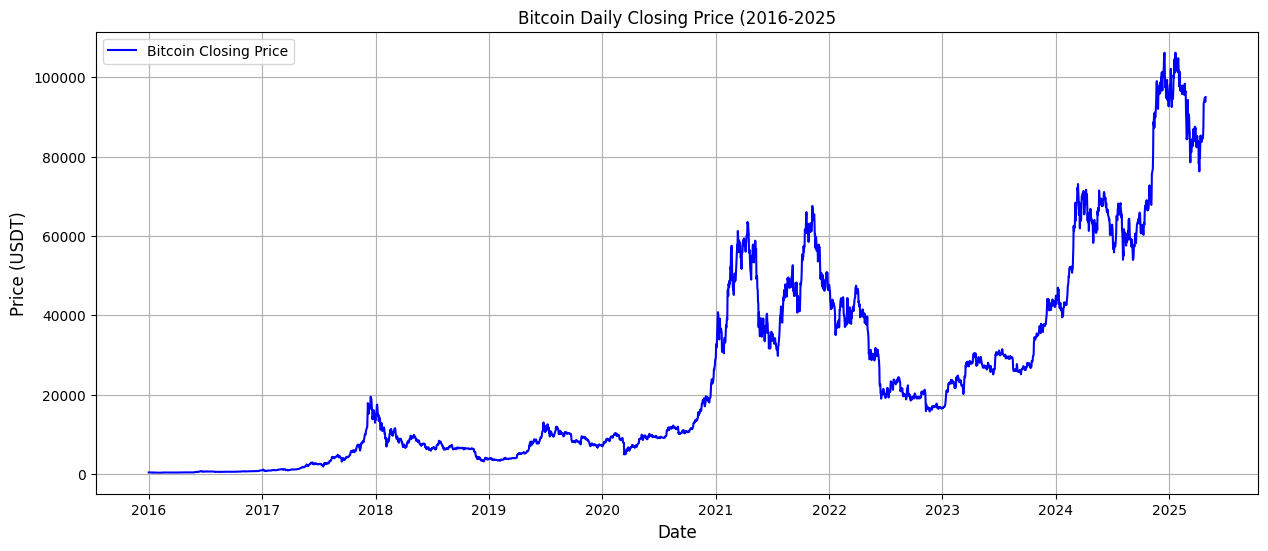

In [232]:
# Plot theb Bitcoin  prices graph
plt.figure(figsize=(15, 6))
plt.plot(BTC_df.index, BTC_df['close'], label='Bitcoin Closing Price', color='blue')
plt.title('Bitcoin Daily Closing Price (2016-2025')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price (USDT)', fontsize=12)
plt.legend()
plt.grid(True)


# Show the plt
plt.show()

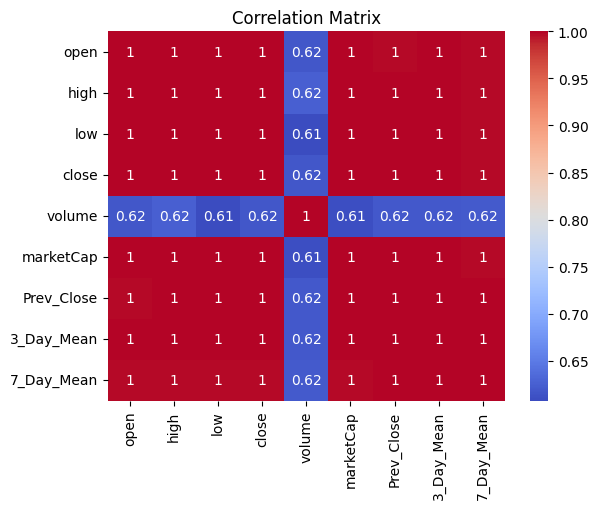

In [233]:

correlation = BTC_df.corr()
sns.heatmap(correlation, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

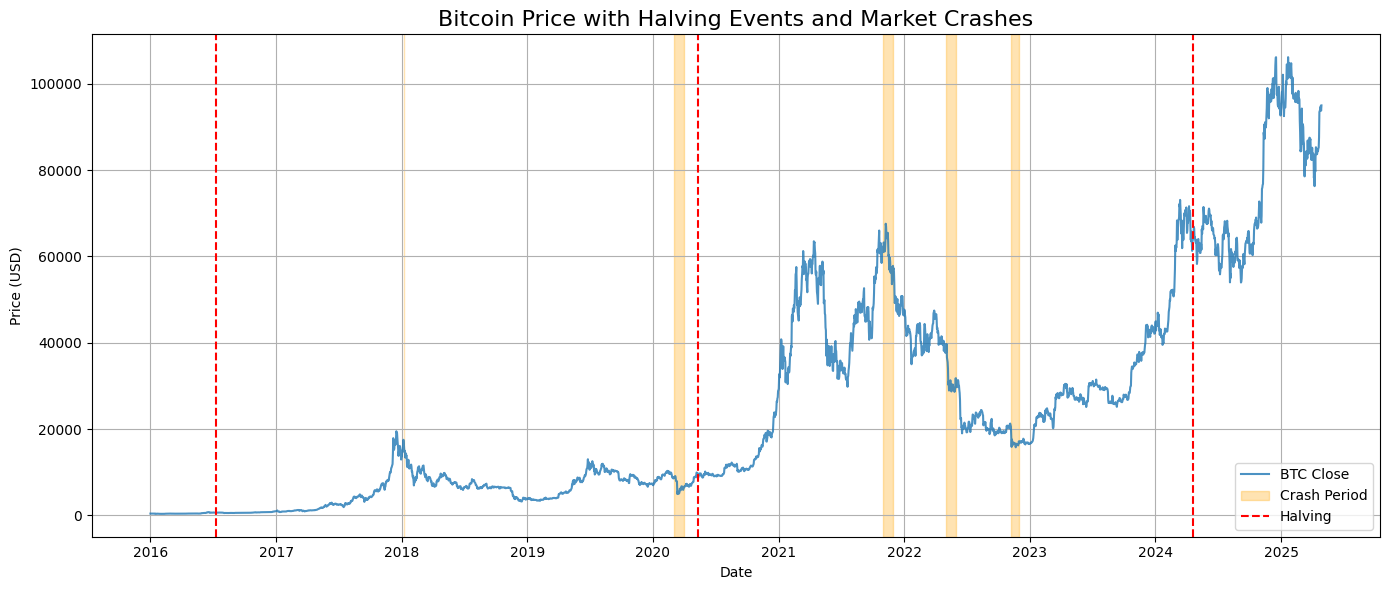

In [234]:

# Nettoyage de l'index (dates sans heures ni timezone)
BTC_df.index = pd.to_datetime(BTC_df.index).normalize()

# Définition des événements de halving et crash (sans timezone)
halving_dates = [
    pd.Timestamp("2016-07-09"),
    pd.Timestamp("2020-05-11"),
    pd.Timestamp("2024-04-20"),
]

crash_periods = [
    (pd.Timestamp("2018-01-06"), pd.Timestamp("2018-01-06")),
    (pd.Timestamp("2020-03-01"), pd.Timestamp("2020-03-31")),
    (pd.Timestamp("2021-11-01"), pd.Timestamp("2021-11-30")),
    (pd.Timestamp("2022-05-01"), pd.Timestamp("2022-05-31")),
    (pd.Timestamp("2022-11-08"), pd.Timestamp("2022-11-30")),
]

# Flags pour événements
BTC_df["halving_flag"] = BTC_df.index.isin(halving_dates)
BTC_df["crash_flag"] = False
for start, end in crash_periods:
    BTC_df.loc[start:end, "crash_flag"] = True

# Attribution de régimes
BTC_df["regime"] = "normal"
BTC_df.loc[BTC_df["halving_flag"], "regime"] = "halving"
BTC_df.loc[BTC_df["crash_flag"], "regime"] = "crash"

# Plot final
plt.figure(figsize=(14, 6))
plt.plot(BTC_df.index, BTC_df["close"], label="BTC Close", alpha=0.8)

# Crashes (zones orange)
for start, end in crash_periods:
    plt.axvspan(start, end, color="orange", alpha=0.3, label="Crash Period" if start == crash_periods[0][0] else "")

# Halvings (lignes rouges)
for date in halving_dates:
    plt.axvline(date, color="red", linestyle="--", linewidth=1.5, label="Halving" if date == halving_dates[0] else "")

plt.title("Bitcoin Price with Halving Events and Market Crashes", fontsize=16)
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [235]:
BTC_df

open          high           low         close  \
timestamp                                                            
2025-04-28  93755.303605  95598.492237  92860.808221  94978.752504   
2025-04-27  94660.909208  95301.206377  93665.397357  93754.846738   
2025-04-26  94714.646371  95251.359438  93927.250628  94646.928112   
2025-04-25  93954.249820  95768.392467  92898.593091  94720.498018   
2025-04-24  93692.395952  94016.194428  91696.714114  93943.793416   
...                  ...           ...           ...           ...   
2016-01-05    433.069000    434.182007    429.675995    431.959991   
2016-01-04    430.061005    434.516998    429.084015    433.091003   
2016-01-03    433.578003    433.743011    424.705994    430.010986   
2016-01-02    434.622009    436.062012    431.869995    433.437988   
2016-01-01    430.721008    436.246002    427.515015    434.334015   

                  volume     marketCap    Prev_Close    3_Day_Mean  \
timestamp                                                            
2025-04-28  3.236345e+10  1.886098e+12           NaN           NaN   
2025-04-27  1.809037e+10  1.861696e+12  94978.752504           NaN   
2025-04-26  1.761283e+10  1.879642e+12  93754.846738  94460.175784   
2025-04-25  4.091523e+10  1.880787e+12  94646.928112  94374.090956   
2025-04-24  3.148318e+10  1.865529e+12  94720.498018  94437.073182   
...                  ...           ...           ...           ...   
2016-01-05  3.452260e+07  6.500393e+09    429.105011    439.704336   
2016-01-04  3.847750e+07  6.515713e+09    431.959991    431.385335   
2016-01-03  3.963380e+07  6.467430e+09    433.091003    431.687327   
2016-01-02  3.009660e+07  6.517390e+09    430.010986    432.179993   
2016-01-01  3.627890e+07  6.529300e+09    433.437988    432.594330   

            7_Day_Mean  halving_flag  crash_flag  regime  
timestamp                                                 
2025-04-28         NaN         False       False  normal  
2025-04-27         NaN         False       False  normal  
2025-04-26         NaN         False       False  normal  
2025-04-25         NaN         False       False  normal  
2025-04-24         NaN         False       False  normal  
...                ...           ...         ...     ...  
2016-01-05  445.196145         False       False  normal  
2016-01-04  443.005144         False       False  normal  
2016-01-03  440.436571         False       False  normal  
2016-01-02  438.411857         False       False  normal  
2016-01-01  435.712429         False       False  normal  

[3406 rows x 12 columns]

In [236]:
from statsmodels.tsa.stattools import adfuller
adf_result = adfuller(BTC_df["close"].dropna())

print("ADF Test Statistic:", adf_result[0])
print("p-value:", adf_result[1])
for key, value in adf_result[4].items():
    print(f"Critical Value ({key}): {value}")

if adf_result[1] < 0.05:
    print("Série stationnaire")
else:
    print("Série non stationnaire")

ADF Test Statistic: -2.157652799042743
p-value: 0.22197229027116538
Critical Value (1%): -3.432288471305038
Critical Value (5%): -2.8623965040462114
Critical Value (10%): -2.5672259336640293
Série non stationnaire


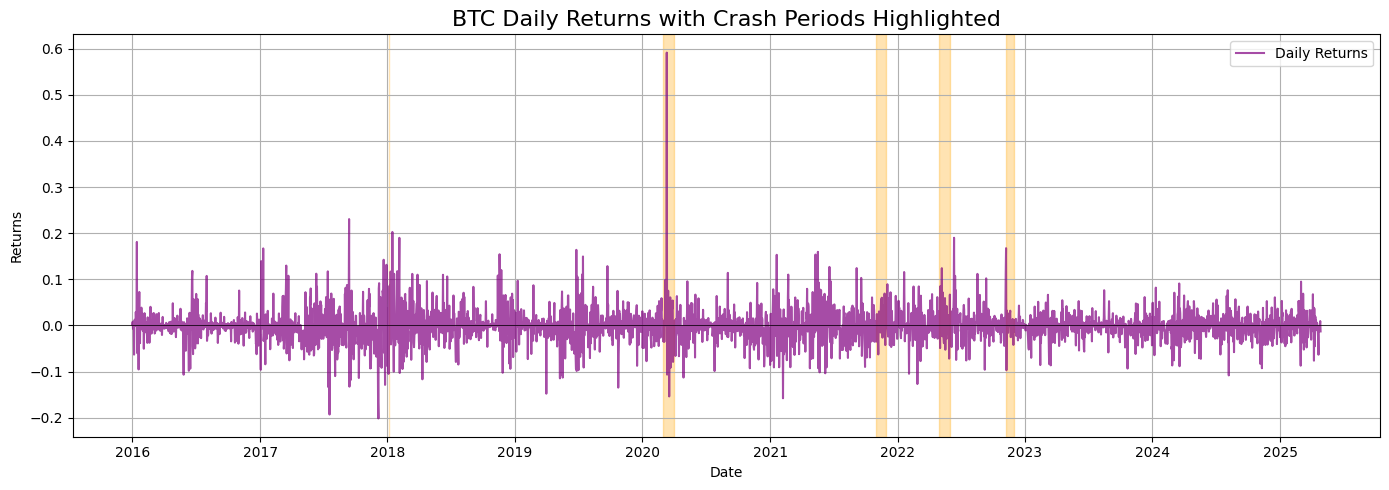

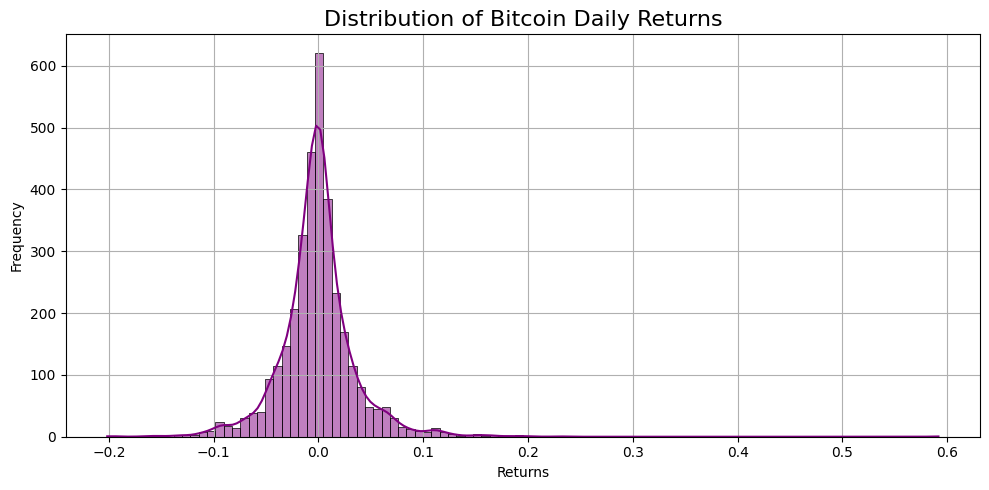

In [237]:
import seaborn as sns
# Returns volatility
BTC_df["returns"] = BTC_df["close"].pct_change()

plt.figure(figsize=(14, 5))
plt.plot(BTC_df.index, BTC_df["returns"], color="purple", alpha=0.7, label="Daily Returns")
plt.axhline(0, color="black", linewidth=0.5)

for start, end in crash_periods:
    plt.axvspan(start, end, color="orange", alpha=0.3)

plt.title("BTC Daily Returns with Crash Periods Highlighted", fontsize=16)
plt.xlabel("Date")
plt.ylabel("Returns")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 5))
sns.histplot(BTC_df["returns"].dropna(), kde=True, bins=100, color="purple")
plt.title("Distribution of Bitcoin Daily Returns", fontsize=16)
plt.xlabel("Returns")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()

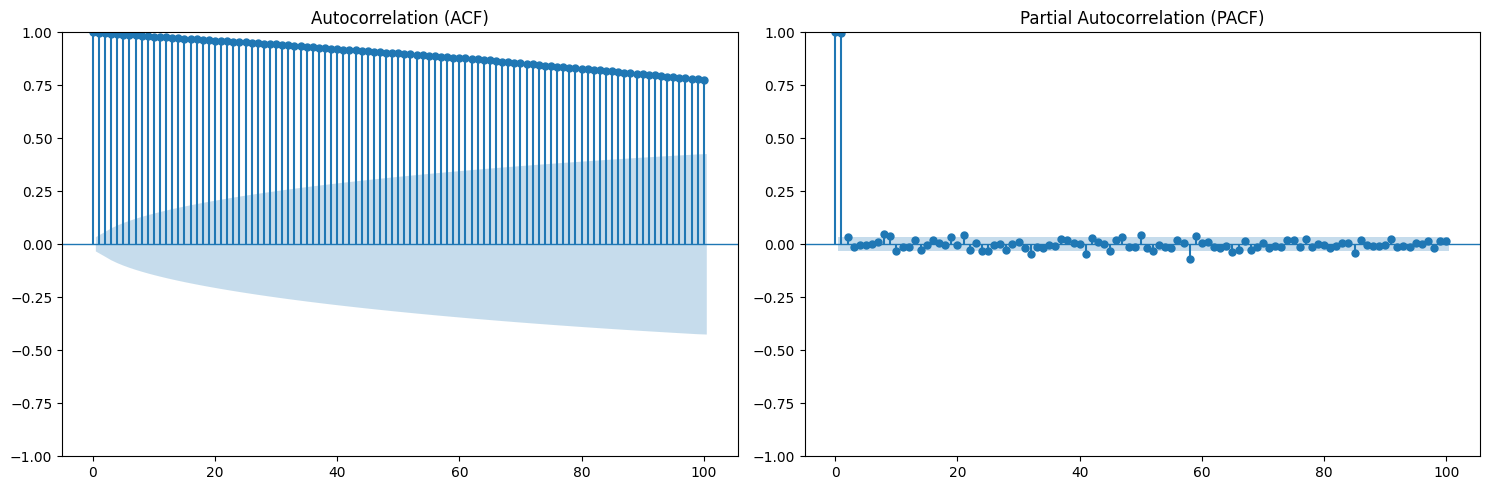

In [238]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
# Autocorrelation and Partial Autocorrelation
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

plot_acf(BTC_df["close"].dropna(), ax=axes[0], lags=100, linewidth=1)
axes[0].set_title("Autocorrelation (ACF)")

plot_pacf(BTC_df["close"].dropna(), ax=axes[1], lags=100, method="ywm", linewidth=1)
axes[1].set_title("Partial Autocorrelation (PACF)")

plt.tight_layout()
plt.show()

In [242]:
# How BTC moves around halving/crash events.
print(BTC_df.groupby("regime")["close"].agg(["mean","std","count"]))

                 mean           std  count
regime                                    
crash    17527.000000           NaN      1
halving  24749.065431  35079.503756      3
normal   24751.244838  25377.397168   3402


# Data Preparation for Models

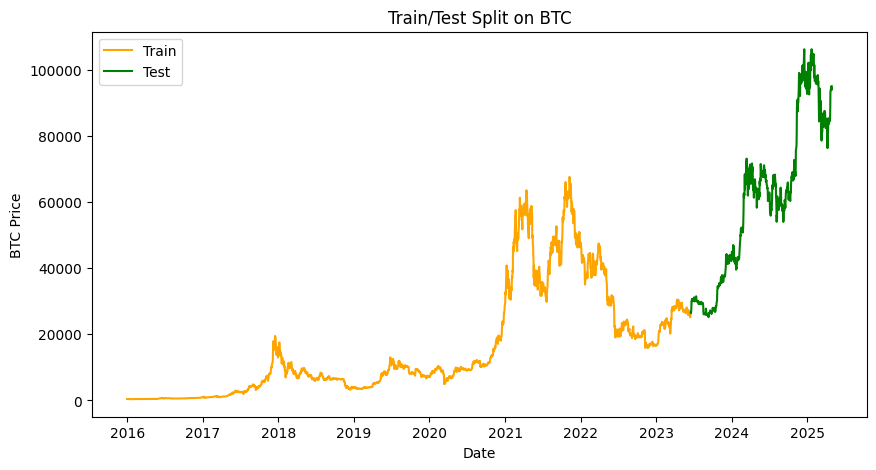

In [255]:
# 1. S'assurer que les dates sont en ordre croissant
BTC_df = BTC_df.sort_index()

# 2. Découpage
split_size = int(0.8 * len(BTC_df))
X_train = BTC_df.index[:split_size]
y_train = BTC_df['close'][:split_size]

X_test = BTC_df.index[split_size:]
y_test = BTC_df['close'][split_size:]

# 3. Affichage
plt.figure(figsize=(10, 5))
plt.plot(X_train, y_train, label='Train', color='orange')
plt.plot(X_test, y_test, label='Test', color='green')
plt.xlabel("Date")
plt.ylabel("BTC Price")
plt.title("Train/Test Split on BTC")
plt.legend()
plt.show()


In [258]:
y_train.head(1)

timestamp
2016-01-01    434.334015
Freq: D, Name: close, dtype: float64

In [259]:
y_test.head(1)

timestamp
2023-06-17    26510.676447
Freq: D, Name: close, dtype: float64

# Auto Arima

In [36]:
from pmdarima import auto_arima as pm
param_grid = {
    "trend":"t",
    "m": 7,  # Seasonal periodicity (e.g., 12 for monthly data)
    "stepwise":
        True,
      # Whether to use stepwise search for model selection
    "error_action": "ignore",  # Action on error ('warn', 'raise', 'ignore')
    "scoring": "mse",  # Scoring metric ('mse' for mean squared error)
    "start_p": 1,  # Start for auto ARIMA
    "d": None,  # Differencing parameter (None for automatic)
    "start_q": 1,  # Start for auto ARIMA
    "max_p":5,  # Maximum AR order
    "max_d": 2,  # Maximum differencing
    "max_q": 5,  # Maximum MA order
    "max_order": 10,  # Maximum total order
    "maxiter": 50,  # Maximum number of iterations
    "suppress_warnings": True,  # Suppress warnings
    "information_criterion": "aic",  # Information criterion for model selection
    "method": "lbfgs", # methode de hyperparameter tuning
    "trend_offset": 1,  # Offset for trend
    "solver": "lbfgs",  # Solver for optimization
    "start_params": None,  # Starting parameters
    "return_valid_fits": False,  # Whether to return valid fits
}



model = pm(train_y["close"], **param_grid, trace=True)
_tmp = model.summary().tables[0]
assert _tmp.data[1][0] == "Model:"
print (_tmp.data)
auto_ariba_bestfit_nm = _tmp.data[1][1] #le nom du modele
auto_ariba_bestfit_cls = model # la classe du modele
is_fitted = True

ValueError: numpy.dtype size changed, may indicate binary incompatibility. Expected 96 from C header, got 88 from PyObject

In [ ]:
f_horizon=len(test_y)
forecast, conf_int = model.predict(
    n_periods=f_horizon, return_conf_int=True
)
conf_int = pd.DataFrame(conf_int)
conf_int.columns = ["lower", "upper"]

forecast_df = pd.DataFrame({"ds": forecast.index, "yhat": forecast.values})

fcast = pd.concat([forecast_df, conf_int], axis=1)



In [ ]:
backtest, backtest_conf_int = model.predict_in_sample(
    return_conf_int=True
)
conf_int_backtest = pd.DataFrame(backtest_conf_int)
conf_int_backtest.columns = ["lower", "upper"]
backtest_df = pd.DataFrame({"ds": backtest.index, "yhat": backtest.values})
bktest = pd.concat([backtest_df, conf_int_backtest], axis=1)

In [ ]:
bktest

ds          yhat         lower         upper
0   2023-02-11      0.435691  -3045.438743   3046.310126
1   2023-02-12  20323.236746  18001.626743  22644.846748
2   2023-02-13  21793.911873  19479.316458  24108.507287
3   2023-02-14  21776.492356  19461.896942  24091.087771
4   2023-02-15  22149.587760  19834.992347  24464.183172
..         ...           ...           ...           ...
465 2024-05-21  70825.552674  68541.024642  73110.080705
466 2024-05-22  70425.773688  68141.245656  72710.301719
467 2024-05-23  69732.676326  67448.148294  72017.204358
468 2024-05-24  68025.739021  65741.210989  70310.267052
469 2024-05-25  68630.793203  66346.265171  70915.321234

[470 rows x 4 columns]

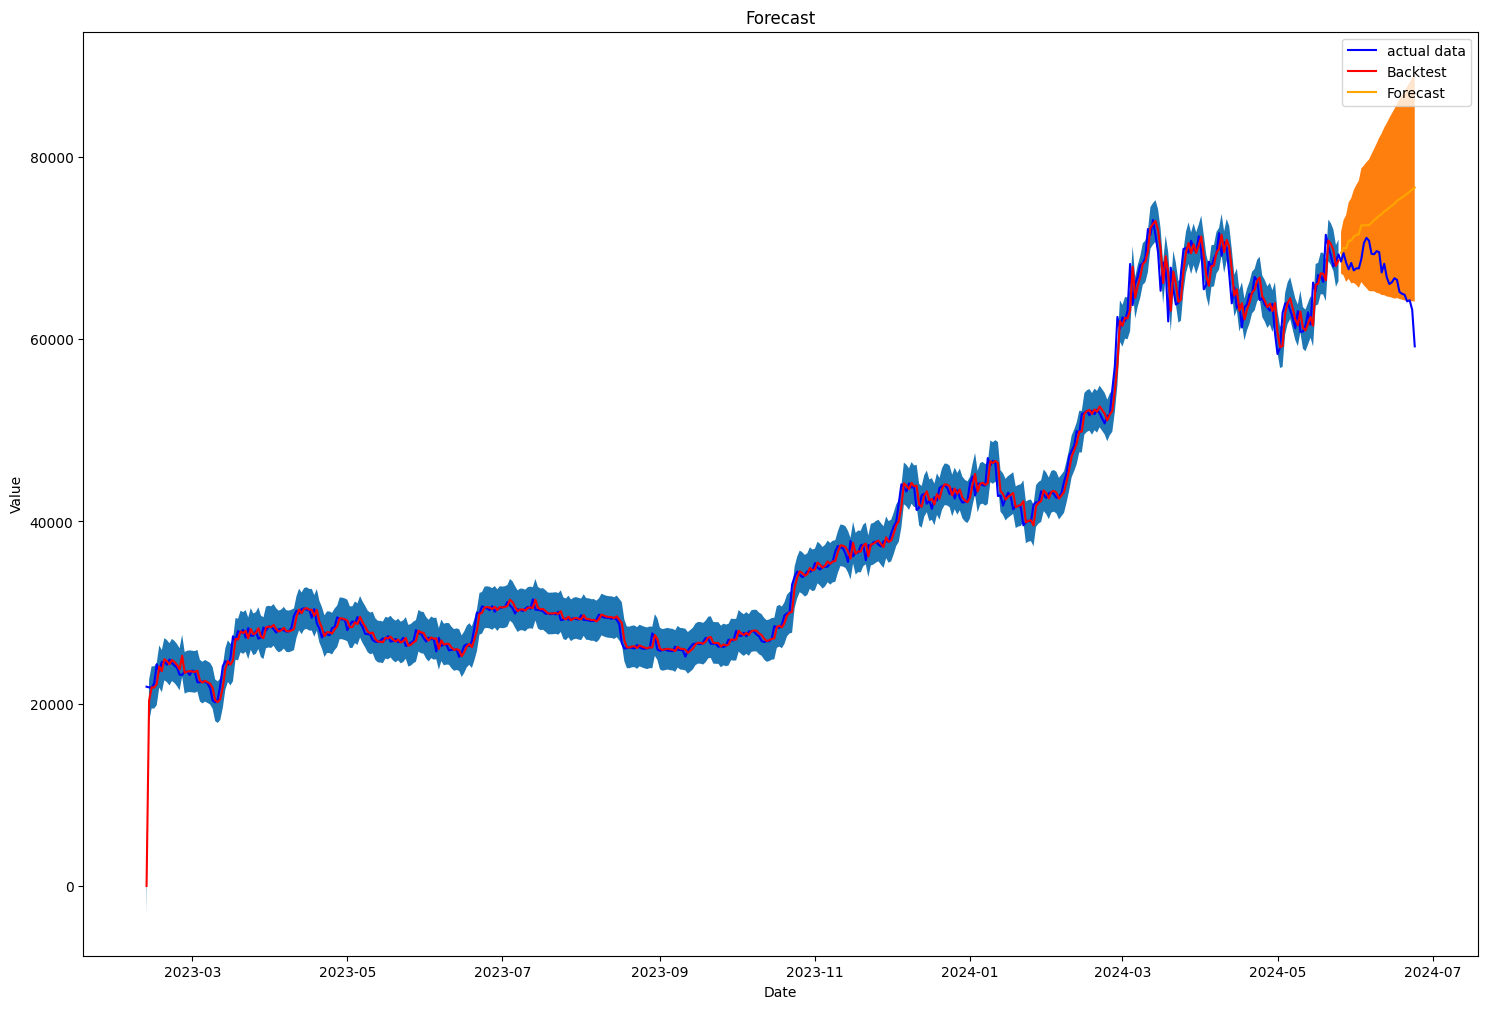

In [ ]:
def plot_forecast(forecast):
    plt.figure(figsize=(18, 12))
    plt.plot(
        BTC_df.index,
        BTC_df["close"],
        label="actual data",
        color="blue",
    )
    ####
    plt.plot(
        bktest["ds"],
        bktest["yhat"],
        label="Backtest",
        color="red",
    )
    plt.fill_between(bktest["ds"], bktest["lower"],bktest["upper"])

    plt.plot(
        fcast["ds"],
        fcast["yhat"],
        label="Forecast",
        color="orange",
    )
    plt.fill_between(fcast["ds"], fcast["lower"],fcast["upper"])
    plt.xlabel("Date")
    plt.ylabel("Value")
    plt.title("Forecast")
    plt.legend()
    plt.show()

plot_forecast(forecast)

# Prophet

In [63]:
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
import numpy as np
import itertools


# Prepare the data for Prophet
# Ensure the 'timestamp' column is in datetime format
df=BTC_df.copy().reset_index(drop=False)
df.rename(columns={'timestamp': 'ds', 'close': 'y'}, inplace=True)

rmses= list ()

param_grid={
    "daily_seasonality": [False, True],
    "weekly_seasonality":[False, True],
    "yearly_seasonality":[True, False],
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5], # to give higher value to prior trend
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0] # to control the flexibility of seasonality components
}

all_params= [
            dict(zip(param_grid.keys(), v))
            for v in itertools.product(*param_grid.values())
]

print(all_params)

# go through each combinations
for params in all_params:
    m= Prophet(**params)

    m= m.add_seasonality(name= 'monthly', period=15, fourier_order=5)
    m= m.add_seasonality(name= "quarterly", period= 30, fourier_order= 10)
    m.fit(df)


    df_cv= cross_validation(m, initial="30 days", period="30 days", horizon="30 days")

    df_p= performance_metrics(df_cv, rolling_window=1)

    rmses.append(df_p['rmse'].values[0])

# find the best parameters
best_params = all_params[np.argmin(rmses)]

print("\n The best parameters are:", best_params)

[{'daily_seasonality': False, 'weekly_seasonality': False, 'yearly_seasonality': True, 'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.01}, {'daily_seasonality': False, 'weekly_seasonality': False, 'yearly_seasonality': True, 'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.1}, {'daily_seasonality': False, 'weekly_seasonality': False, 'yearly_seasonality': True, 'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 1.0}, {'daily_seasonality': False, 'weekly_seasonality': False, 'yearly_seasonality': True, 'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 10.0}, {'daily_seasonality': False, 'weekly_seasonality': False, 'yearly_seasonality': True, 'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.01}, {'daily_seasonality': False, 'weekly_seasonality': False, 'yearly_seasonality': True, 'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.1}, {'daily_seasonality': False, 'weekly_seasonality': False, 'yearly_seasonality': 

16:37:32 - cmdstanpy - INFO - Chain [1] start processing
16:37:34 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/112 [00:00<?, ?it/s]16:37:34 - cmdstanpy - INFO - Chain [1] start processing
16:37:34 - cmdstanpy - INFO - Chain [1] done processing
  1%|          | 1/112 [00:00<00:50,  2.18it/s]16:37:34 - cmdstanpy - INFO - Chain [1] start processing
16:37:35 - cmdstanpy - INFO - Chain [1] done processing
  2%|▏         | 2/112 [00:01<01:03,  1.74it/s]16:37:35 - cmdstanpy - INFO - Chain [1] start processing
16:37:35 - cmdstanpy - INFO - Chain [1] done processing
16:37:35 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
16:37:35 - cmdstanpy - INFO - Chain [1] start processing
16:37:35 - cmdstanpy - INFO - Chain [1] done processing
  3%|▎         | 3/112 [00:01<00:59,  1.83


 The best parameters are: {'daily_seasonality': False, 'weekly_seasonality': False, 'yearly_seasonality': True, 'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 10.0}


In [ ]:
{'changepoint_range': 0.8, 'daily_seasonality': False, 'weekly_seasonality': False, 'yearly_seasonality': True, 'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.01}

In [64]:
model = Prophet(**{'daily_seasonality': False, 'weekly_seasonality': False, 'yearly_seasonality': True, 'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 10.0})
model.fit(df)

# Create future dates for prediction
future = model.make_future_dataframe(periods=30)  # Predicting for the next 30 days

# Make predictions
forecast = model.predict(future)


01:32:09 - cmdstanpy - INFO - Chain [1] start processing
01:32:10 - cmdstanpy - INFO - Chain [1] done processing


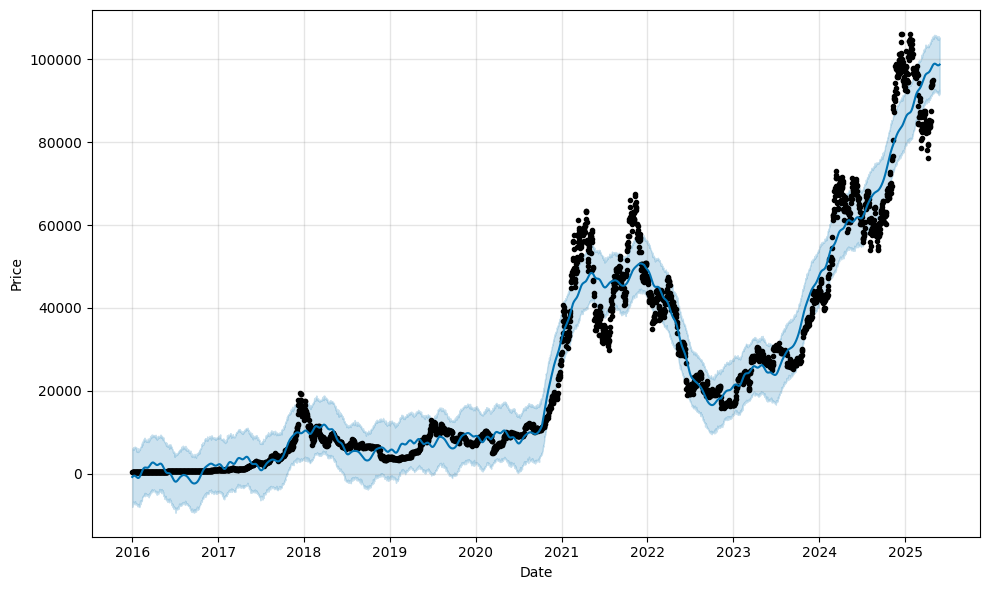

In [65]:
figure_1 = model.plot(forecast,
                    xlabel='Date',
                    ylabel='Price')


# LSTM

In [261]:
class LSTMTrainer:
    def __init__(self, BTC_df) -> None:
        self.target_data = BTC_df.copy().reset_index()
        self.target_data = self.target_data[["close", "halving_flag", "crash_flag"]]
        self.model = None
        self.history = None
        self.scaler = None

    def preper_dataset(self, training_size, time_step=1):
        self.scaler = MinMaxScaler(feature_range=(0, 1))
        self.target_data = self.scaler.fit_transform(self.target_data)

        train_len = int(len(self.target_data) * training_size)
        train_data = self.target_data[:train_len]
        test_data = self.target_data[train_len:]

        def _create_dataset(dataset, time_step=1):
            dataX, dataY = [], []
            for i in range(len(dataset) - time_step - 1):
                a = dataset[i:(i + time_step), :]  # Toutes les colonnes (close, halving, crash)
                dataX.append(a)
                dataY.append(dataset[i + time_step, 0])  # close = target (colonne 0)
            return np.array(dataX), np.array(dataY)

        X_train, y_train = _create_dataset(train_data, time_step)
        X_test, y_test = _create_dataset(test_data, time_step)

        print(f"X_train shape: {X_train.shape}")
        print(f"X_test shape: {X_test.shape}")

        return X_train, y_train, X_test, y_test

    def create_model(self, X_train):
        self.model = Sequential()
        self.model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
        self.model.add(LSTM(units=50, return_sequences=False))
        self.model.add(Dense(units=1))
        self.model.compile(optimizer='adam', loss='mean_squared_error')
        print(self.model.summary())
        return self.model

    def train_model(self, X_train, y_train, X_test, y_test):
        early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
        self.history = self.model.fit(
            X_train, y_train,
            validation_data=(X_test, y_test),
            epochs=100,
            batch_size=32,
            verbose=1,
            callbacks=[early_stopping]
        )

        # Courbes de perte
        plt.plot(self.history.history['loss'], label='Training Loss')
        plt.plot(self.history.history['val_loss'], label='Validation Loss')
        plt.title('Model Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()

        return self.history

    def inference_model(self, X_train, y_train, X_test, y_test):
        # Prédictions
        train_predict = self.model.predict(X_train)
        test_predict = self.model.predict(X_test)

        # Création d’un scaler spécifique à la colonne 'close' uniquement
        close_scaler = MinMaxScaler(feature_range=(0, 1))
        close_data = self.target_data[:, 0].reshape(-1, 1)
        close_scaler.fit(close_data)

        # Inverser uniquement les prédictions 'close'
        train_predict_rescaled = close_scaler.inverse_transform(train_predict).flatten()
        test_predict_rescaled = close_scaler.inverse_transform(test_predict).flatten()

        # Inverser aussi les y_train et y_test pour comparer correctement
        y_train_rescaled = close_scaler.inverse_transform(y_train.reshape(-1, 1)).flatten()
        y_test_rescaled = close_scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()

        # Afficher les erreurs RMSE
        print("RMSE Train:", math.sqrt(mean_squared_error(y_train_rescaled, train_predict_rescaled)))
        print("RMSE Test :", math.sqrt(mean_squared_error(y_test_rescaled, test_predict_rescaled)))

        # Reconstruction des séries complètes pour affichage
        total_close = close_scaler.inverse_transform(close_data).flatten()

        look_back = 1
        trainPredictPlot = np.empty_like(total_close)
        trainPredictPlot[:] = np.nan
        trainPredictPlot[look_back:len(train_predict_rescaled) + look_back] = train_predict_rescaled

        testPredictPlot = np.empty_like(total_close)
        testPredictPlot[:] = np.nan
        testPredictPlot[len(train_predict_rescaled) + (look_back * 2) + 1:len(total_close) - 1] = test_predict_rescaled

        # Affichage des courbes
        plt.figure(figsize=(12, 6))
        plt.plot(total_close, label='True Price')
        plt.plot(trainPredictPlot, label='Train Prediction')
        plt.plot(testPredictPlot, label='Test Prediction')
        plt.title("Bitcoin Price Prediction")
        plt.xlabel("Time step")
        plt.ylabel("BTC Price")
        plt.legend()
        plt.show()



In [262]:
trainer = LSTMTrainer(BTC_df = BTC_df)

In [263]:
#X_train,y_train, X_test, y_test = trainer.preper_dataset(training_size=0.7)
X_train, y_train, X_test, y_test = trainer.preper_dataset(training_size=0.7)

X_train shape: (2382, 1, 3)
X_test shape: (1020, 1, 3)


In [264]:
trainer.create_model(X_train)

c:\Users\Sabrine\Desktop\TFM_BTC_SCRIPT\btc_env\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_28 (LSTM)                  │ (None, 1, 50)          │        10,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_29 (LSTM)                  │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,051 (121.29 KB)

 Trainable params: 31,051 (121.29 KB)

 Non-trainable params: 0 (0.00 B)

None


<Sequential name=sequential_14, built=True>

Epoch 1/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0350 - val_loss: 0.0605
Epoch 2/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0054 - val_loss: 0.0026
Epoch 3/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.2692e-04 - val_loss: 0.0015
Epoch 4/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.1024e-04 - val_loss: 0.0013
Epoch 5/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 9.9631e-05 - val_loss: 0.0012
Epoch 6/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 9.7418e-05 - val_loss: 0.0011
Epoch 7/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 9.4929e-05 - val_loss: 6.6589e-04
Epoch 8/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 9.9647e-05 - val_loss: 7.1330e-04
Epoch 9/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 8.3342e-05 - val_loss: 4.2134e-04
Epoch 10/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 8.2092e-05 - val_loss: 3.3488e-04
Epoch 11/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 7.7132e-05 - val_loss: 4.0937e-04
Epoch 1

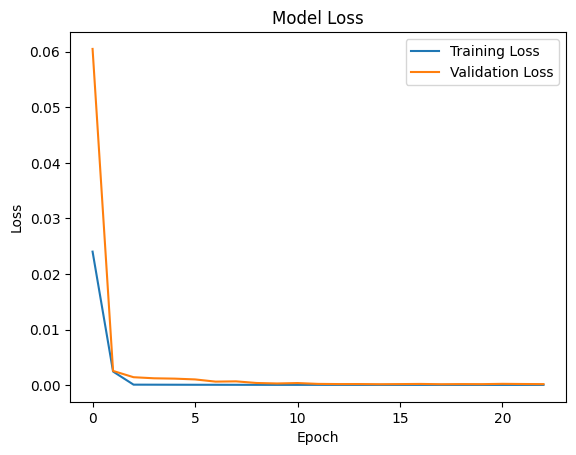

In [265]:
trainer.train_model(X_train,y_train, X_test, y_test)

75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
RMSE Train: 0.008627276520882639
RMSE Test : 0.014111195813926638


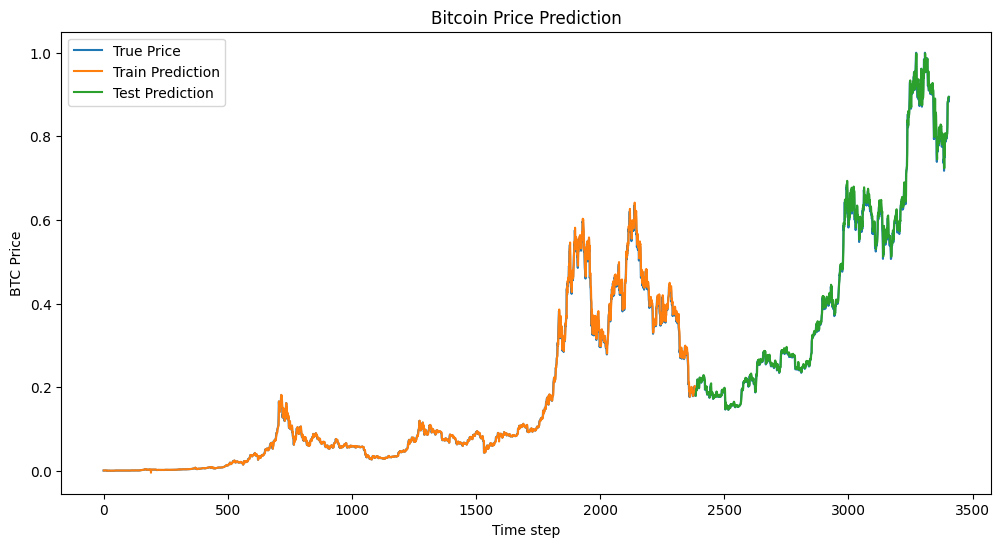

In [266]:
trainer.inference_model(X_train,y_train, X_test, y_test)
